In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, ResNet50, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization, Input, Concatenate, Multiply, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# مسارات البيانات
base_dir = r"C:\Users\a7sn4\Desktop\xray\chest_xray"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
batch_size = 32

train_data = train_datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
val_data = val_datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='binary')
test_data = val_datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=1, class_mode='binary', shuffle=False)

def se_block(input_tensor, ratio=8):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = Multiply()([input_tensor, se])
    return x

def build_super_ensemble():
    input_tensor = Input(shape=(224, 224, 3))

    base1 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
    base2 = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)
    base3 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)

    for layer in base1.layers:
        layer.trainable = False
    for layer in base2.layers:
        layer.trainable = False
    for layer in base3.layers:
        layer.trainable = False

    x1 = GlobalAveragePooling2D()(se_block(base1.output))
    x2 = GlobalAveragePooling2D()(se_block(base2.output))
    x3 = GlobalAveragePooling2D()(se_block(base3.output))

    merged = Concatenate()([x1, x2, x3])
    merged = BatchNormalization()(merged)
    merged = Dense(256, activation='relu')(merged)
    merged = Dropout(0.4)(merged)
    output = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=input_tensor, outputs=output)
    return model

model = build_super_ensemble()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("super_ensemble_model.keras", save_best_only=True, monitor='val_loss', verbose=1)
]

history = model.fit(train_data, validation_data=val_data, epochs=25, callbacks=callbacks)

loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2%}")


Num GPUs Available: 0
Found 5216 images belonging to 2 classes.
Found 1192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


C:\Users\a7sn4\AppData\Local\Temp\ipykernel_16512\3931965751.py:56: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base3 = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8406 - loss: 0.3362
Epoch 1: val_loss improved from inf to 0.24465, saving model to super_ensemble_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1306s 8s/step - accuracy: 0.8410 - loss: 0.3356 - val_accuracy: 0.9354 - val_loss: 0.2446 - learning_rate: 1.0000e-04
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9305 - loss: 0.1595
Epoch 2: val_loss improved from 0.24465 to 0.18489, saving model to super_ensemble_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1102s 7s/step - accuracy: 0.9306 - loss: 0.1594 - val_accuracy: 0.9304 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9452 - loss: 0.1290
Epoch 3: val_loss improved from 0.18489 to 0.13870, saving model to super_ensemble_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 1004s 6s/step - accuracy: 0.9452 - loss: 0.1290 - val_accuracy: 0.9488 - val_loss: 0.1387 - learning_rate: 1.0000e-04
Epoch 4/25
163/163 ━━━━

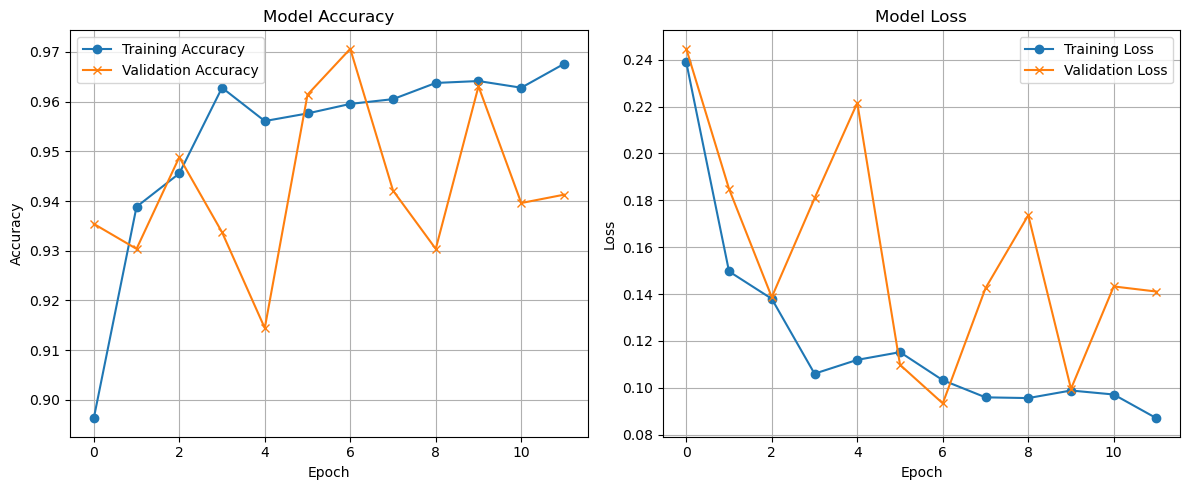

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# رسم منحنى الدقة Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# رسم منحنى الخسارة Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
# حفظ النموذج بصيغة .keras
model.save("super_ensemble_model072025.keras")


In [6]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# تحميل النموذج
model = load_model("super_ensemble_model.keras")  # أو .h5

# دالة التنبؤ
def predict_xray(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]

    label = "PNEUMONIA" if prediction >= 0.5 else "NORMAL"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    return f"Prediction: {label} ({confidence:.2%})"

# واجهة Gradio
interface = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="X-ray Pneumonia Detection",
    description="Upload a chest X-ray image to detect Pneumonia."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Flask code:

In [14]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# تحميل النموذج
model = load_model("super_ensemble_model072025.keras")  # أو .h5

# دالة التنبؤ
def predict_xray(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]

    label = "PNEUMONIA" if prediction >= 0.5 else "NORMAL"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    return f"Prediction: {label} ({confidence:.2%})"

# واجهة Gradio
interface = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="X-ray Pneumonia Detection",
    description="Upload a chest X-ray image to detect Pneumonia."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 65s 65s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get true labels
y_true = test_data.classes

# Predict probabilities
y_prob = model.predict(test_data, verbose=1)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_prob > 0.5).astype("int32").flatten()


624/624 ━━━━━━━━━━━━━━━━━━━━ 86s 126ms/step


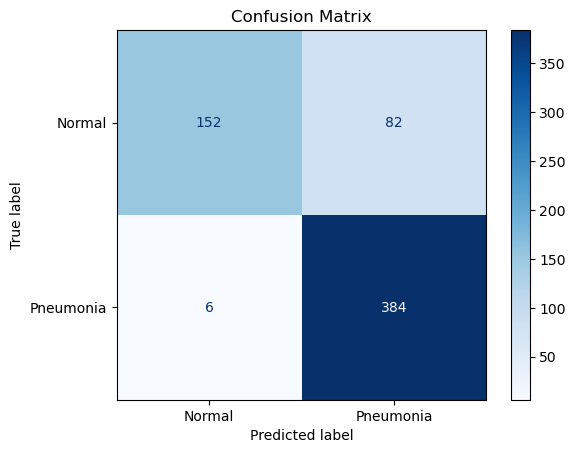

In [8]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


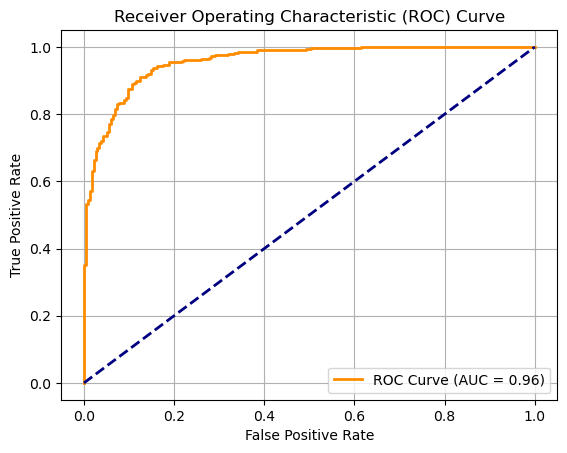

In [9]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [10]:
report = classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"])
print(report)


              precision    recall  f1-score   support

      Normal       0.96      0.65      0.78       234
   Pneumonia       0.82      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


In [ ]:
pip install opencv-python matplotlib


In [11]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

def get_img_array(img_path, size=(224, 224)):
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_output, conv_outputs)

    # Global average pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0-1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


C:\Users\a7sn4\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_2']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


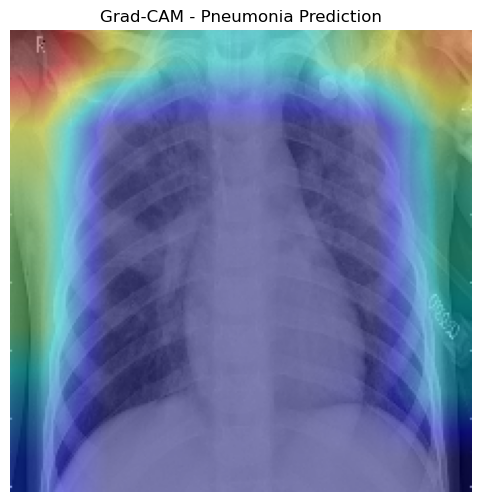

In [12]:
# Specify an X-ray image path
img_path = "C:/Users/a7sn4/Desktop/xray/chest_xray/test/PNEUMONIA/person3_virus_16.jpeg"
img_array = get_img_array(img_path)

# Use a conv layer from your model (e.g., 'top_conv' in EfficientNetB0 or 'conv5_block3_out' in ResNet50)
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv")  # try MobileNet/ResNet if different

# Load original image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

# Convert heatmap to RGB
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on original image
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Save or show
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.title("Grad-CAM - Pneumonia Prediction")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.show()


In [13]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 224, 224, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 224, 224, 3)       │               7 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_1 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             288 │ block1a_se_reduce[0][0]    │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 39,075,944 (149.06 MB)

 Trainable params: 3,057,153 (11.66 MB)

 Non-trainable params: 29,904,483 (114.08 MB)

 Optimizer params: 6,114,308 (23.32 MB)

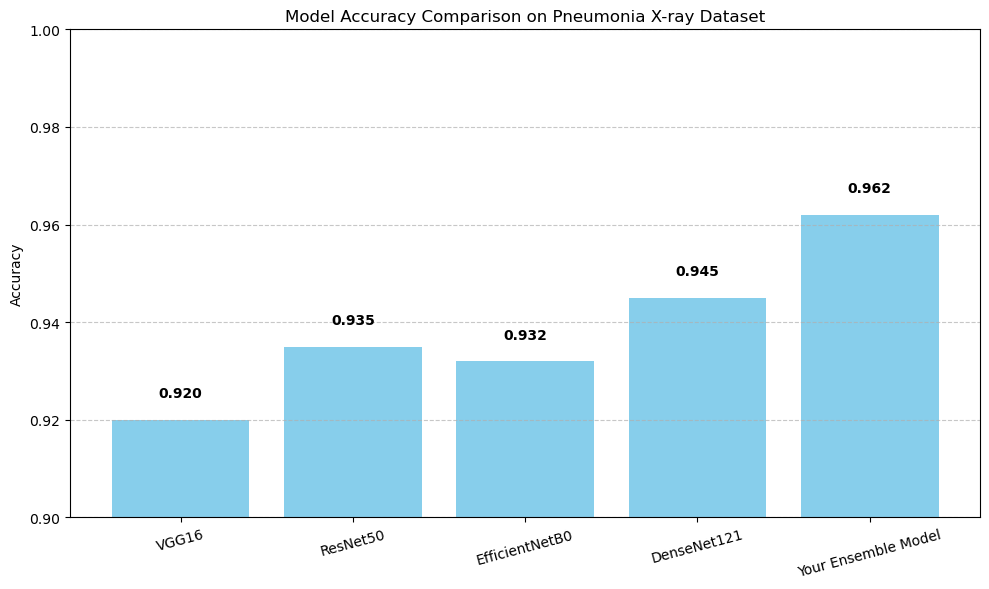

In [15]:
import matplotlib.pyplot as plt

models = ['VGG16', 'ResNet50', 'EfficientNetB0', 'DenseNet121', 'Your Ensemble Model']
accuracies = [0.92, 0.935, 0.932, 0.945, 0.962]

plt.figure(figsize=(10,6))
plt.bar(models, accuracies, color='skyblue')
plt.ylim(0.9, 1.0)
plt.title('Model Accuracy Comparison on Pneumonia X-ray Dataset')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=15)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.004, f"{acc:.3f}", ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# الحصول على التنبؤات الاحتمالية من النموذج
y_pred_prob = model.predict(test_data)

# تحويل الاحتمالات إلى فئات ثنائية (0 أو 1)
y_pred = (y_pred_prob >= 0.5).astype(int).reshape(-1)

# الفئات الحقيقية
y_true = test_data.classes

# التقرير الكامل (Accuracy, Precision, Recall, F1)
target_names = list(test_data.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# مصفوفة الالتباس (اختياري)
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


C:\Users\a7sn4\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 447s 539ms/step
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.65      0.78       234
   PNEUMONIA       0.82      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624

Confusion Matrix:
[[152  82]
 [  6 384]]


In [20]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

model = load_model("super_ensemble_model.keras")

def preprocess_image(img):
    img = img.resize((224, 224))
    img = np.array(img) / 255.0
    if img.shape[-1] == 4:
        img = img[..., :3]
    img = np.expand_dims(img, axis=0)
    return img

def predict_xray(img):
    img_array = preprocess_image(img)
    prediction = model.predict(img_array)[0][0]
    label = "PNEUMONIA" if prediction >= 0.5 else "NORMAL"
    confidence = prediction if prediction >= 0.5 else 1 - prediction
    return f"Prediction: {label} ({confidence:.2%})"

interface = gr.Interface(
    fn=predict_xray,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="X-ray Pneumonia Detection",
    description="Upload a chest X-ray image to detect Pneumonia."
)

interface.launch()


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 47s 47s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step